# EuroSciPy 2011: Introduction to Scientific Computing with SciPy

**Prerequisites:** Ability to edit and run Python scripts, familiarity with
NumPy arrays

**Software requirements:** 
[IPython](http://ipython.org),
[NumPy](http://numpy.org), [SciPy](http://scipy.org), [Cython](http://cython.org) (optional), [matplotlib](http://matplotlib.sf.net)

<br/>
[Python(x,y)](http://www.pythonxy.com) and [EPD](http://www.enthought.com/products/epd.php) provide
one-click installers.

<br/>
Make sure that you can execute the following commands before the tutorial:

    import numpy
    print numpy.__version__

    import scipy
    print scipy.__version__

    import matplotlib.pyplot as plt
    plt.plot([1, 2, 3])
    plt.show()

**Content:** We give a brief overview of the SciPy tool stack: numpy, scipy, matplotlib
and IPython.  We then interactively explore different components of SciPy,
such as optimisation, integration, clustering, image processing and
elementary linear algebra.  To conclude, we briefly discuss some external
tools that form part of the eco-system, such as nosetests, Cython and
Sphinx.

<style type="text/css">
    .exercise {
        border: solid 3px #AAE;
        background: #EEF;
        padding: 50px 10px 50px 10px;
        display: inline-block;
        font-size: 110%;
    }
</style>

In [1]:
import numpy as np
print(np.__version__)

import scipy as sp
print(sp.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

1.11.0.dev0+941a4e0
0.16.0


In [2]:
f = open('triceratops.obj', 'r')

lines = f.readlines()
vertices = []

for l in lines:
    items = l.split()
    if len(items) == 4 and items[0] == 'v':
        vertices.append(
           [float(f) for f in items[1:]]
        )
        
points = np.array(vertices)

(2832, 3)


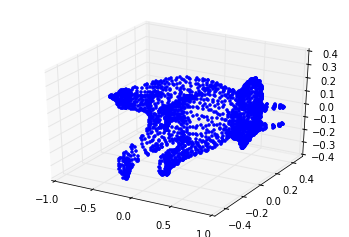

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.gca(projection='3d')

print(points.shape)
x, y, z = points.T

plt.plot(x, y, z, '.')

In [4]:
np.loadtxt('triceratops_clean.obj')

array([[ 0.576047  , -0.0207502 , -0.0851141 ],
       [ 0.582657  ,  0.0181254 , -0.0958034 ],
       [ 0.611766  ,  0.0140973 , -0.0836525 ],
       ..., 
       [ 0.978493  ,  0.0131669 , -0.00660234],
       [ 0.980024  ,  0.00981772, -0.00616342],
       [ 0.981451  ,  0.00729448, -0.00273231]])

## Subdivision

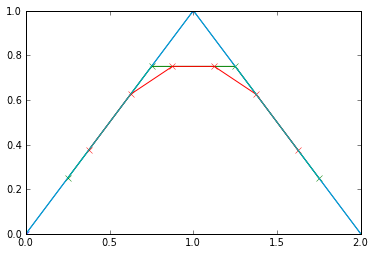

In [5]:
from IPython.core.display import Image
Image(filename='subdiv.png')

In [6]:
points = np.load('hand.npy')
print(points[:5])

[[ 1.64516129  1.16145833]
 [ 1.64516129  1.59375   ]
 [ 1.35080645  1.921875  ]
 [ 1.375       2.18229167]
 [ 1.68548387  1.9375    ]]


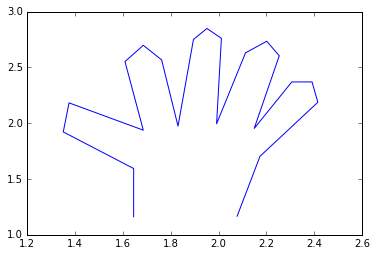

In [7]:
plt.plot(points[:, 0], points[:, 1])

Given a sequence

<br/>
$$p^i = (\ldots,p_{-1}^{i}, p_{0}^{i}, p_{1}^{i}, p_{2}^{i} \ldots)$$
<br/>

subdivision doubles the number of points, using two rules.  The first
rule-set is called Doo-Sabin:
<br/>
<br/>

$$p_{2j}^{i+1} = \frac{3}{4} p_j^i + \frac{1}{4} p_{j+1}^i$$

<br/>
$$p_{2j+1}^{i+1} = \frac{1}{4} p_j^i + \frac{3}{4} p_{j+1}^i$$
<br/>

The second is called Catmull-Clark:
<br/>
<br/>

$$p_{2j}^{i+1} = \frac{1}{8} p_{j-1}^i + \frac{6}{8} p_j^i + \frac{1}{8} p_{j+1}^i$$

<br/>
$$p_{2j+1}^{i+1} = \frac{4}{8} p_j^i + \frac{4}{8} p_{j+1}^i$$
<br/>



<div class="exercise">

**Exercise**
    
1. Load the given coordinates from ``hand.npy``, using ``numpy.load``.
2. Plot the coordinates.
3. Write a function to apply Doo-Shabin subdivision.
4. Apply the function a few times, and see whether the hand is smoothed
   out as expected.
5. Can you modify your code to use NumPy arrays?
6. Time the performance of the Python vs. the NumPy implementations.

Here's a Python implementation of Doo-Sabin:

In [8]:
def refine(p):
    new_p = []
    for jj in range(2 * (len(p) - 1)):
        j = jj // 2
        if (jj % 2) == 0:
            # Even points
            new_p.append(3/4. * p[j] + 1/4. * p[j + 1])
            # Why the "." after the 4?
            # What is the dimension of p[j]?
        else:
            # Odd points
            new_p.append(1/4. * p[j] + 3/4. * p[j + 1])
    return np.array(new_p)

Nr of points: (82, 2)


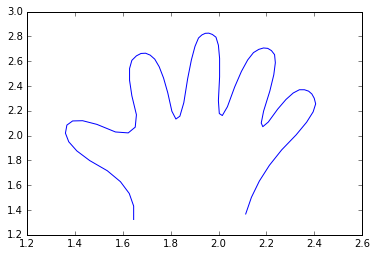

In [9]:
new_p = points.copy()

for i in range(2):
    new_p = refine(new_p)

print("Nr of points:", new_p.shape)
x, y = new_p.T # What happens here?

plt.plot(x, y, '-')

In [10]:
def refine_np(p):
    new_p = np.zeros((2 * (len(p) - 1), 2))
    
    new_p[::2] = 3/4. * p[:-1] + 1/4. * p[1:]
    new_p[1::2] = 1/4. * p[:-1] + 3/4. * p[1:]
    
    return new_p

Nr of points: (82, 2)


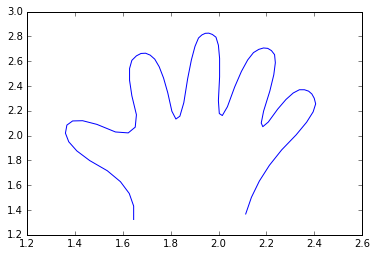

In [11]:
new_p = points.copy()

for i in range(2):
    new_p = refine_np(new_p)

print("Nr of points:", new_p.shape)
x, y = new_p.T

plt.plot(x, y, '-')

In [12]:
%timeit refine(points)

1000 loops, best of 3: 392 µs per loop


In [13]:
%timeit refine_np(points)

The slowest run took 19.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 27 µs per loop


In [14]:
def refine_catmull_np(p):
    p = np.vstack((p[0], p, p[-1]))
    
    # Make sure edges don't drop off
    new_p = np.zeros((2 * (len(p) - 2), 2))
    
    new_p[::2] = 1/8. * p[:-2] + \
                 6/8. * p[1:-1] + \
                 1/8. * p[2:]
    new_p[1::2] = 4/8. * p[1:-1] + 4/8. * p[2:]
    
    return new_p

Nr of points: (88, 2)


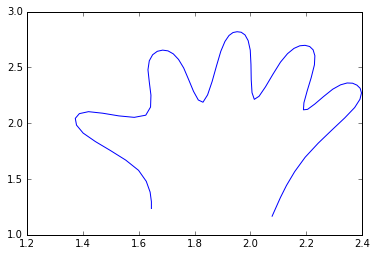

In [15]:
new_p = points.copy()

for i in range(2):
    new_p = refine_catmull_np(new_p)

print("Nr of points:", new_p.shape)
x, y = new_p.T

plt.plot(x, y, '-')

In [16]:
import scipy.signal as signal

def refine_arb(p, mask_even=None, mask_odd=None):
   a = signal.correlate2d(p.T, np.atleast_2d(mask_even),
                          mode='valid')
   b = signal.correlate2d(p.T, np.atleast_2d(mask_odd),
                          mode='valid')
        
   out_cols = a.shape[1] + b.shape[1]
   out = np.zeros((out_cols, 2))
   out[::2] = a.T
   out[1::2] = b.T
        
   return out

Nr of points: (82, 2)


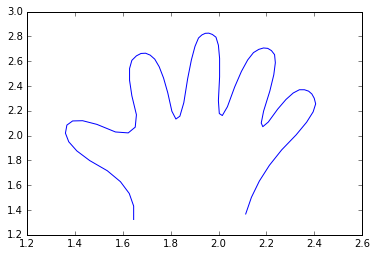

In [17]:
new_p = points.copy()

for i in range(2):
    new_p = refine_arb(new_p,
                       mask_even=[3/4., 1/4.],
                       mask_odd=[1/4., 3/4.])

print("Nr of points:", new_p.shape)
x, y = new_p.T

plt.plot(x, y, '-')

Nr of points: (76, 2)


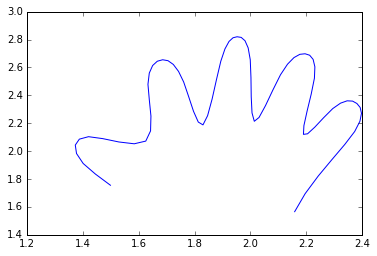

In [18]:
new_p = points.copy()

for i in range(2):
    new_p = refine_arb(new_p,
             mask_even=(1/8. * np.array([1, 6, 1])),
             mask_odd=(1/8. * np.array([0, 4, 4])))

print("Nr of points:", new_p.shape)
x, y = new_p.T

plt.plot(x, y, '-')

In [19]:
%timeit refine_arb(points, mask_even=(1/8. * np.array([1, 6, 1])), mask_odd=(1/8. * np.array([0, 4, 4])))

The slowest run took 4.97 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 125 µs per loop


Nr of points: (10, 2)


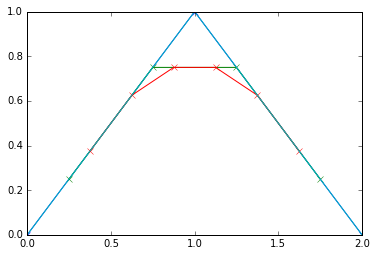

In [20]:
new_p = points.copy()
points = np.array([[0, 0], [1, 1], [2, 0.]])
new_p = points.copy()

for i in range(3):
    x, y = new_p.T
    plt.plot(x, y, '-x')
    new_p = refine(new_p)

print("Nr of points:", new_p.shape)
x, y = new_p.T # What happens here?

plt.plot(points[:, 0], points[:, 1])

## FFT Image Denoising

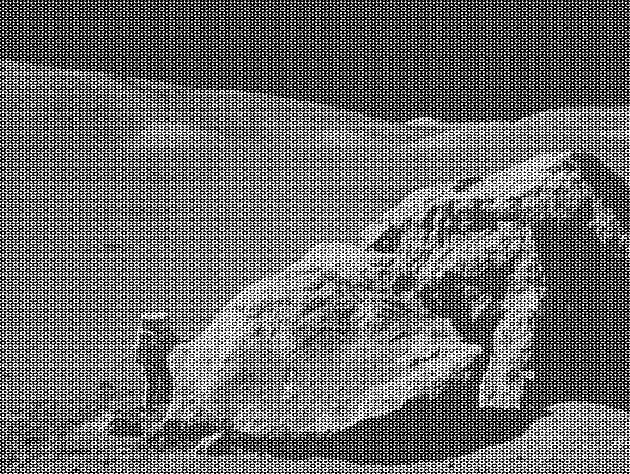

In [21]:
from IPython.core.display import Image
Image(filename='moonlanding.png')

<div class="exercise">
**Exercise**
    
1. Examine the provided image ``moonlanding.png``, which is heavily contaminated
   with periodic noise.  In this exercise, we aim to clean up the noise using the 
   Fast Fourier Transform.
    
2. Load the image using ``plt.imread``.
    
3. Find and use the FFT built into ``numpy`` or ``scipy``, and plot the
   spectrum (Fourier transform of) the image.
    
   Do you have any trouble visualising the spectrum?  If so, why?
   
4. The spectrum consists of high and low frequency components. The noise
   is contained in the high-frequency part of the spectrum, so set some
   of those components to zero (use array slicing).
    
5. Apply the inverse Fourier transform to see the resulting image.


In [22]:
def plot_spectrum(F):
    plt.imshow(np.log(5 + np.abs(F)))

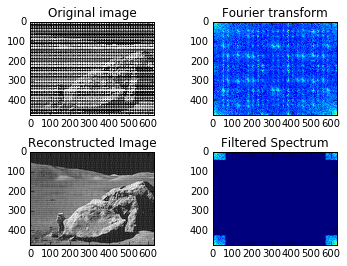

In [23]:
im = plt.imread('moonlanding.png').astype(float)


# Compute the 2d FFT of the input image
F = np.fft.fft2(im)

# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.1

# Call ff a copy of the original transform.  Numpy arrays have a copy
# method for this purpose.
ff = F.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = ff.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
ff[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
ff[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0 #@

# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = np.fft.ifft2(ff).real
    
# Show the results

plt.figure()
plt.subplot(221)
plt.title('Original image')
plt.imshow(im, plt.cm.gray)

plt.subplot(222)
plt.title('Fourier transform')
plot_spectrum(F)

plt.subplot(224)
plt.title('Filtered Spectrum')
plot_spectrum(ff)

plt.subplot(223)
plt.title('Reconstructed Image')
plt.imshow(im_new, plt.cm.gray)

# Adjust the spacing between subplots for readability 
plt.subplots_adjust(hspace=0.4)


## Counting grains and bubbles

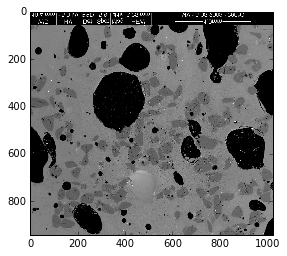

In [24]:
img = np.flipud(plt.imread('bubbles.jpg'))
plt.imshow(img, cmap=plt.cm.gray)

<div class="exercise">

**Exercise**
    
1. Open the image ``bubbles.jpg`` and display it.
   (If the image is displayed upside down, use ``np.flipud``
   or specify the ``origin`` parameter to ``imshow``).

2. This Scanning Element Microscopy image shows a glass sample
   (light gray matrix) with some bubbles (black) and unmolten
   sand grains (dark gray). We wish to determine the fraction
   of the sample covered by these three phases,
   and to estimate the number of sand grains and bubbles,
   their average sizes, etc.

3. Crop the image to remove the lower panel with measure information.

4. Filter the image with a median filter to clean up some noise
   and to make the regions more smooth.

5. Using the histogram of the filtered image, determine thresholds
   that allow to define masks for sand pixels, glass pixels
   and bubble pixels.

6. Display an image in which the three phases are colored with
   three different colors.

   Use morphological operators to clean the different phases.

7. Attribute labels to all bubbles and sand grains, and remove
   from the sand mask grains that are smaller than 10 pixels.
   To do so, use ``ndimage.sum`` or ``np.bincount`` to compute
   the grain sizes.

8. Compute the mean size of bubbles.

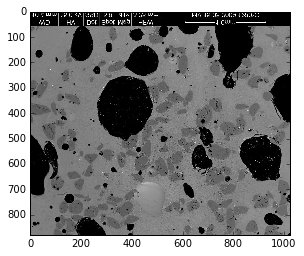

In [25]:
img_clean = img[:880, :]
plt.imshow(img_clean, cmap=plt.cm.gray)

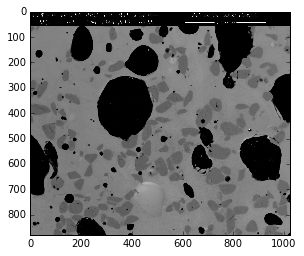

In [26]:
import scipy.ndimage as ndi
img_med = ndi.median_filter(img_clean, size=5)
plt.imshow(img_med, cmap=plt.cm.gray)

(array([ 200297.,   11899.,    6427.,    2519.,    1963.,    1114.,
            855.,     436.,     646.,     588.,     618.,     453.,
            589.,     644.,     654.,     507.,     659.,     801.,
            803.,     721.,    1065.,    1240.,    1720.,    2518.,
          12224.,   36309.,   44459.,   29900.,   25922.,   15350.,
          13184.,   12484.,   37418.,   85385.,  122757.,   81814.,
          85331.,   41465.,   10023.,    1869.]),
 array([   0.  ,    3.75,    7.5 ,   11.25,   15.  ,   18.75,   22.5 ,
          26.25,   30.  ,   33.75,   37.5 ,   41.25,   45.  ,   48.75,
          52.5 ,   56.25,   60.  ,   63.75,   67.5 ,   71.25,   75.  ,
          78.75,   82.5 ,   86.25,   90.  ,   93.75,   97.5 ,  101.25,
         105.  ,  108.75,  112.5 ,  116.25,  120.  ,  123.75,  127.5 ,
         131.25,  135.  ,  138.75,  142.5 ,  146.25,  150.  ]),
 <a list of 40 Patch objects>)

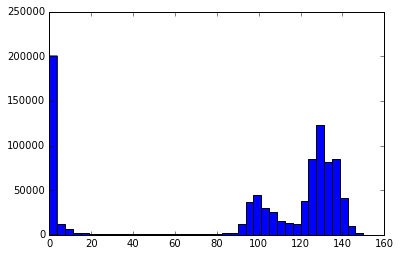

In [27]:
plt.hist(img_med.flat, bins=40, range=(0, 150))

Based on the histogram, it looks like we should threshold at
50 and 120 to separate bubbles (black), sand (dark) and glass (light).

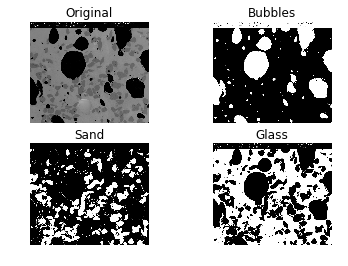

In [28]:
bubbles = (img_med <= 50)
sand = (img_med > 50) & (img_med <= 120)
glass = (img_med > 120)

def plot_images(cmap=plt.cm.gray):
    for n, (name, image) in \
        enumerate([('Original', img_med),
                   ('Bubbles', bubbles),
                   ('Sand', sand),
                   ('Glass', glass)]):
    
        plt.subplot(2, 2, n + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(name)
        plt.axis('off')
        
plot_images()

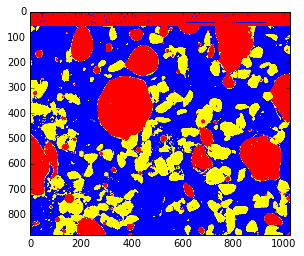

In [29]:
def plot_color_overlay():
    all = np.zeros((img_clean.shape[0],
                    img_clean.shape[1], 3)) # Color image

    # You shouldn't run this if bubbles isn't a mask
    # -- otherwise, fancy indexing instead of masking
    assert(bubbles.dtype == np.bool)
    
    all[bubbles] = (1, 0, 0)
    all[sand] = (1, 1, 0)
    all[glass] = (0, 0, 1)

    plt.imshow(all)

plot_color_overlay()


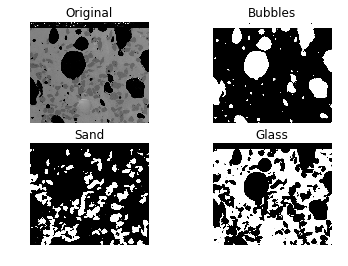

In [30]:
for img in (sand, bubbles, glass):
    img[:] = ndi.binary_opening(img, np.ones((5, 5)))
    img[:] = ndi.binary_closing(img, np.ones((5, 5)))
    
plot_images()

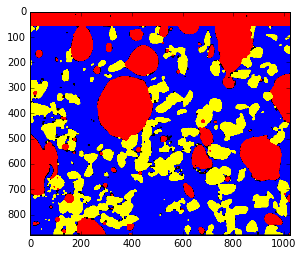

In [31]:
plot_color_overlay()

106 regions found in Sand
Mean obj area 1822
63 regions found in Bubbles
Mean obj area 3636
28 regions found in Glass
Mean obj area 16903


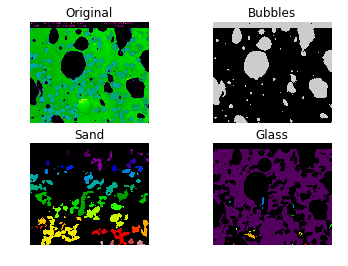

In [32]:
# Convert to int so we can store the labels
bubble = bubbles.astype(int)
sand = sand.astype(int)
glass = glass.astype(int)

for name, img in [('Sand', sand),
                  ('Bubbles', bubbles),
                  ('Glass', glass)]:
    labels, count = ndi.label(img)
    print('%s regions found in %s' % (count, name))
    img[:] = labels
    
    obj_areas = [np.sum(labels == i) for \
                 i in range(1, labels.max())]
    print("Mean obj area %d" % np.mean(obj_areas))

plot_images(cmap=plt.cm.spectral)